# Segmentation of Skeletal Stem Cell Nuclei in Phase Contrast images

**Stem Cells** are of great interest from many points of view, since they are
central to generation, homeostatic regeneration and repair of tissues. Despite
the excitement due to their potential marvelous therapeutic use, much about them
is still unknown.

One of these still undiscovered aspects concerns the structure of the growth of
the clonal progeny. If we were to trace the "ancestry tree" of a cell, tracing a
line for each visible cell and a bifurcation at each mitotic step, how does the
tree look like? Does it have a symmetric or an asymmetric structure? What does
this tell us about the original cell?

**Skeletal Stem Cells** (SSCs) are a type of Stem Cell which comes from human
bones.  We know that they proliferate *in vitro* and create clonal colonies from
fibroblast colony-forming units (called CFU-Fs). These colonies of SSCs reach
full confluency over a period of two weeks.

We study the **time evolution of a SSC clonal colony** extracted from the bone
marrow of a patient. The sample is cleaned from impurities and put in a Petri
dish along with the culture medium. The dish is then installed in the phase
contrast microscope, which will be taking pictures of selected Fields of View
(FOVs) every twenty minutes. The data acquisition lasts about two weeks, at the
end of which we expect that the clonal colony gets so densely packed that cells
start to get out of the FOV. Note that some of the FOVs do not generate colonies
at all: cells that are quiescent are removed from the selection of FOVs after a
while.

In [1]:
import os
from pathlib import Path
from functools import partial
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Concatenate, Input, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy as bce_loss
from tensorflow.keras import backend as K
from tensorflow.nn import weighted_cross_entropy_with_logits
from tensorflow.math import reduce_mean
from tensorflow.keras.callbacks import ModelCheckpoint

2024-01-17 20:18:30.659088: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 20:18:30.696657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 20:18:30.696697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 20:18:30.697753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 20:18:30.704740: I tensorflow/core/platform/cpu_feature_guar

## Tracking Cells in Phase Contrast Images of SSCs

In order to trace the **phylogenetic tree** of cells it is necessary to see at
each frame where each cell is located, whether they perform mitosis and which
cells are generated from the mitosis of which other cell. Such a task is done
by **cell tracking**.

In order to track a cell it is necessary to understand where it is located. One
popular way to achieve this is to perform what is called a **semantic
segmentation**: if we think of the image as an array of elements, semantic
segmentation means that we say whether each one of these array elements belongs
to a class or not.

Semantic segmentation can:

- Be performed over *slides* (i.e. the image is a 2D array) or *volumes* (the image
    is a 3D array). The former can be, for example, the case of microscopy of
    bacteria or cells, and the latter can be the case of MRI images of body
    organs (brain, liver, heart, etc.).
- Be performed over *colored images* (i.e. each array element is a 3D array in
    itself, usually containing an integer value from 0 to 255 that refers to the
    intensity of the red, green or blue component) or *greyscale images* (i.3.
    each array element is an integer value from 0 to 255 referring to the
    brightness of the pixel). The former is the case, for example, of
    fluorescence microscopy and the latter can be the case of phase contrast
    microscopy of unstained samples (which is exactly our case).
- Yield as a result *two classes* (one relevant class, aka the foreground, and
    the background) or *more than two classes* (multiple relevant classes, e.g.
    the brain tumor, the rest of the brain, the background).

We can attempt semantic segmentation by very simple and affordable means:
**image processing operations**, or a combination of them, can yield to sensible
results depending on the type of image that we are sampling.

For example, images of cells with fluorescent dyes can have very evident
features highlighting different parts of the cell, even by using multiple stains
for different components. In that case, for example, operations such as the
*watershed algorithm* can be performed and may work well enough for the
purposes of semantic segmentation.

We might as well have unstained samples of round objects with clear boundaries.
In that case we might use *boundary detection* algorithms in order to trace the
paths of boundaries of cells, hence locating their position.

Ours is none of these cases. In fact our images are **phase contrast** images,
which creates artefacts that do not allow a trivial segmentation e.g. by
thresholding, and the objects of our study are SSCs which have a
**fibroblastoid** shape, meaning that their structural appearance is that of
fibroblasts. These types of cells assume a heterogeneous variety of shapes, like
a *reticular* conformation or a *fusiform* shape; their dimension varies a lot
and over the course of the colony formation they can overlap between each other,
making trivial segmentation processes very difficult.

The lab's current state of art process for segmentation of SSCs implies the use
of an image processing based segmentation routine over their **cytoplasm**. This
process works very well for early stages of the colony formation, but becomes
ineffective as cells start to stretch and overlap. This happens after ca. five
to six generations, and consequently impedes any further cell tracking.

We attempt at **augmenting the tracking algorithm** by providing the already
developed algorithm for segmentation of cell cytoplasm with **additional
informations about cell nuclei**. We hope to achieve this by training a Deep
Convolutional Neural Networks to perform semantic segmentation of SSC nuclei.

For this purpose, two main goals were set:

- To **create a dataset** specific to our goal, selecting FOVs, tagging nuclei
    and preprocessing images in order to fit the input requirements of the DNN.
    Our images are **phase contrast grayscale images** of **fibroblastoid**
    cells, and our ground truths label the foreground (i.e. nuclei) from the
    background (i.e. all the rest). We would like to point out that the tagging
    process depends entirely on the tagger and her/his perception and knowledge.
    This already gives us a hint that overfitting too much will probably be
    problematic. We will not thoroughly present this part of the research work.
- To **create and train a model** for semantic segmentation to be feeded with
    the dataset we previously created and test its performance.

## Hardware and software setup

For the purposes of the creation of the dataset scripts using ImageJ, Python and
Bash were written.

For the DNN part instead the **Tensorflow/Keras** on Python backend was used.
OpenCV, NumPy, Matplotlib and Standard Library APIs have also been used.

## The images and the ground truths

### Properties of the images

The images we are studying, as already mentioned, are grayscale images of SSCs. SSCs
are, like many other biological assays, transparent items. This means that transmitted
light is not in any way attenuated by the sample, making the method uneffective for these
types of samples.

![](assets/microscopy_types.jpg)

For this reason Frits Zernike invented **phase-contrast microscopy** which earned him a
Nobel Prize in Physics in 1953. This type of microscope measured not only the amplitude
of transmitted light, but also its **phase-shifts**. These are shown as brightness changes,
depending on the properties of the medium. This type of microscopy has been really important
in studying assays that are not stained with fluorescent dyes.

However, these techniques introduces some artefacts on the images that makes it difficult
to directly use the acquired images for quantitative purposes. Along these artefacts, as
it often happens when using microscopes we get unwanted *vignette* effects, *blurs* due to
unstable focus, inconsistencies in how the software *overlaps* different tiles of the same
FOV to recreate the image.

They are 512x512 pixels images.

### Properties of the ground truth

The ground truths, instead, are generated from the manual dataset creation process.
They are of the same dimension of images, and have pixelwise value 0 if the pixel in the image
is a nucleus pixel, and 255 instead if the pixel is a nucleus pixel.

## Data Exploration

Let us first look at the data that we have at hand. First of all, how big is the dataset?

In [2]:
dataset_path = Path('../data/dataset')
img_path = dataset_path / 'img' / 'img'
img_list = list(img_path.glob('*.tif'))
print(f'There are {len(img_list)} images.')

There are 1105 images.


Let's take a look at these images and see how they look like.

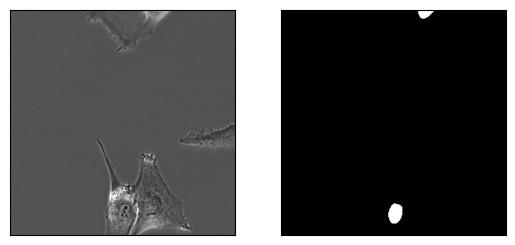

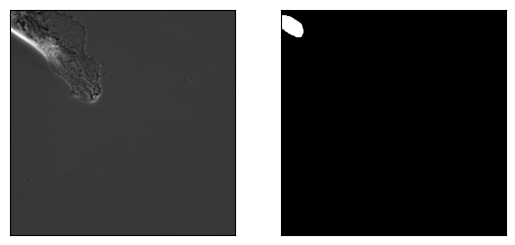

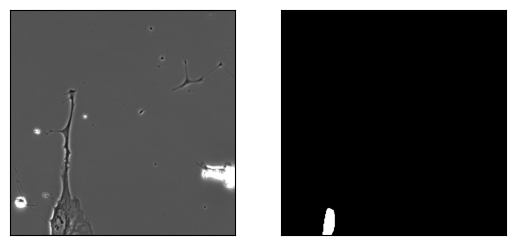

In [3]:
for img_file in img_list[:3]:
    gt_file = dataset_path / 'gt' / 'gt' / img_file.name
    img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(str(gt_file), cv2.IMREAD_GRAYSCALE)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.subplot(122)
    plt.imshow(gt, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()
    plt.close()

As we can see, not a lot of space is taken up by the foreground with
respect to the background. This constitutes a **class imbalance**
between foreground and background that will be useful to us in the
following.

It can hence be useful to roughly estimate how imbalanced is, on
average, the amount of foreground with respect to the background.

Let's say we take all the ground truths and average over them the
foreground to background ratio. We define a function to compute
these weights.

In [4]:
def compute_weights(img):
    '''
    Get weights for the image.

    This function takes as input an image in a 2d array format (i.e. a matrix)
    and returns the weights, respectively, for the FOREGROUND and the BACKGROUND.
    Useful for purposes of computing the correct weights for the Weighted
    Binary Cross Entropy.

    Uses numpy backend i.e. for flatten method, etc.

    :param img: 2d image array
    :returns: tuple with the weight for the foreground and for the background
    '''

    img_f = np.where(img.flatten() > 0, 1, 0)
    bg_weight = img_f.sum() / img_f.size

    return (1 - bg_weight, bg_weight)

In [5]:
gt_path = dataset_path / 'gt' / 'gt'
fg_weights = []
for gt_file in gt_path.glob('*.tif'):
    gt = cv2.imread(str(gt_file), cv2.IMREAD_GRAYSCALE)
    fg_weights.append(compute_weights(gt)[0])

In [6]:
print('Foreground ratio mean is', np.mean(fg_weights), 'while background ratio mean is', 1-np.mean(fg_weights), '.')
print('Foreground is', np.mean(fg_weights)/(1-np.mean(fg_weights)), 'times more abundant than background.')

Foreground ratio mean is 0.9916568876931031 while background ratio mean is 0.008343112306896883 .
Foreground is 118.85934783274392 times more abundant than background.


This means that more or less we have two orders of magnitude between the two classes.

## Load the dataset for training

Let us now create a loader function for the dataset. This function will:

- Look for folders in the dataset, and look for subfolders for each class. Since
    we have only one class, our folder structure will be trivial (`img/img` for
    images and `gt/gt` for ground truths).
- Split the dataset in training and test set. For reproducibility, the seed will
    always be initialized to 42.
- Augment the data, since we are tackling a computer vision problem. Operations
    such as *width shift*, *height shift*, *zoom*, *horizontal flip*, *vertical
    flip*, *brightness* change are applied.
- Data generators are returned as a result.

In [7]:
def get_tif_loader(dataset_path='../data/dataset/', train_test_split=0.3, batch_size=14):
    '''
    Default loader for TIFF images.

    This function will lazy load TIFF images for training and validation purposes in Keras
    pipelines. It uses the soon-to-be deprecated component ``ImageDataGenerator`` since the
    new `recommended <https://keras.io/api/data_loading/image/>` ``image_dataset_from_directory``
    does NOT support TIFF images loading.

    The folder pointed to by ``dataset_path`` should contain an ``img/img`` folder for images
    and a ``gt/gt`` folder for masks / ground truth images. The double subfoldering is necessary
    due to the requirement of the ``ImageDataGenerator`` that the dataset should be subfoldered by
    class, but since we have only one class (i.e. the foreground) we will use just one subfolder.

    Data augmentation steps are performed, such as:

    * Width Shift
    * Height Shift
    * Zoom
    * Horizontal Flip
    * Vertical Flip
    * Brightness

    These are also applied as TTA (Test Time Augmentations).

    The masks / ground truth images are transformed in binary arrays of 0/1 values.

    Then two zipped generators for the images and the ground truths, respectively for the training
    and test set subdivided by using the ``train_test_split`` parameter, are returned.

    :param dataset_path: path of the dataset containing the ``gt`` and ``img`` subfolders
    :param train_test_split: ratio of data that will be used for test purposes
    :param batch_size: batch size integer value
    :returns: two generators, one for the training and the other for the test set
    '''
    
    seed = 42
    
    fullds_path = dataset_path
    
    data_gen_dict = partial(
        dict,
        validation_split=train_test_split,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range=(0.1, 0.9)
    )
    
    img_data_gen_dict = data_gen_dict()
    gt_data_gen_dict = data_gen_dict(
        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
    )
    
    img_data_gen = ImageDataGenerator(**img_data_gen_dict)
    gt_data_gen = ImageDataGenerator(**gt_data_gen_dict)
    
    img_train_gen = img_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'img'),
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='training'
    )
    
    gt_train_gen = gt_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'gt'),
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='training'
    )
    
    
    img_test_gen = img_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'img'),
        seed=seed,
        batch_size=1,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='validation'
    )
    
    gt_test_gen = gt_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'gt'),
        seed=seed,
        batch_size=1,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='validation'
    )
    
    train_gen = zip(img_train_gen, gt_train_gen)
    test_gen = zip(img_test_gen, gt_test_gen)

    return train_gen, test_gen

In [8]:
train_gen, test_gen = get_tif_loader(dataset_path='../data/dataset/')

Found 774 images belonging to 1 classes.
Found 774 images belonging to 1 classes.
Found 331 images belonging to 1 classes.
Found 331 images belonging to 1 classes.


## The model for semantic segmentation

Let us first understand what is the best fitted model for our problem.
Our problem is that of finding the position of nuclei by finding the
pixels corresponding to nuclei in the image, namely **semantic segmentation**.

The goal of semantic segmentation is, in general, to classify each pixel of a
2D/3D image according to the class they belong to. In our case the two classes
would be the foreground (i.e. nuclei) and the background (i.e. everything else).

Note that semantic segmentation does not distinguish two adjacent objects of the
same kind: if two adjacent nuclei are detected, only one blob would appear in the
mask because the goal is not to highlight each nucleus, but to highlight pixels
that belong to the *nucleus* class in general. This will not be, however, a problem
in our case, since for the nuclei we would like to track are not in a *confluent* stage
(i.e. they have not yet filled the FOV).

### Convolutional Neural Networks

A famous example of Deep Neural Network used in Computer Vision are **Convolutional
Neural Networks** (CNNs): they leverage an idea coming from how the visual cortex
might work and apply it to the learning process of visual features.

In particular, the idea coming from Hubel and Wiesel that earned them a Nobel Prize
in Physiology or Medicine in 1981 is that neurons in the visual cortex of humans do
not respond to stimuli coming from the whole visual field, but each neuron only reacts
to stimuli coming from a *local receptive field*.

This idea insipred DNN researchers such as Yann LeCun, who devised networks that were
much less memory-intensive with respect to fully connected networks and that yielded
optimal results on real world data.

CNN architectures are mainly based on two components:

- **convolutional layers** implement the idea that we mentioned previously, hence are not
    fully connected to the adjacent layers but have only connections to a small local field.
    The entity of the small local field is given by the `kernel_size` and `stride` parameters.
    Each layer has a 2D size and also a *depth*, given by the number of *filters*. Filters
    are the weights (i.e. eigenvalues) of the image in the basis of kernels (i.e. eigenvectors),
    and they are randomly initialized to capture different features of the image.
- **pooling layers**, similarly to a convolutional layer, has the local receptive field structure
    but does not have any weight. We choose to use `MaxPool`, meaning that of each small group
    of pixel we choose the maximum value.

There are many architectural choices that can be made for a Convolutional Neural Network.
For the purposes of semantic segmentation, and in particular in the field of **biomedical
imaging**, the so-called **U-Net** has become a standard. It was devised by Olaf Ronneberger
and collaborators in 2015, and owes its name to its characteristic U-shape.

### U-Net's Network Architecture

<img src="assets/unet.png" alt="" style="width: 500px;"/>

**U-Net** [Ronneberger et al., 2015] has two main parts: an *encoder* part and an *decoder* part.
It is an evolution of the network devised by [Long et al., 2015], which only had a sequence
of convolution blocks for the encoder but had a single upsampling (deconvolution) layer.

<img src="assets/long.jpg" alt="" style="width: 500px;"/>

The fundamental units of the U-Net are *convolutional blocks*. They take an array as input
and perform the following successive operations upon them:

- a *convolution* layer: performs the convolution operation over a certain number of filters;
- a *dropout* layer: deactivates some of the neurons during training to avoid overfitting [Hinton et al., 2012];
- a *batch normalization* layer: performs zero-centering and normalization over the entire batch [Ioffe and Szegedy, 2015];
- an *activation* layer: it is a fundamental part of DNNs and it determines the activation or not of neurons between one layer and another, and in this case it has been chosen to be `ReLU` because it is continuous and it is fast to compute;

This is done twice for each *convolutional block*.

In [9]:
def conv_block(input, num_filters, dropout=0.1):
    '''
    Single convolutional block.

    This is the building block of the U-Net. It is made of two repeated sub-blocks, each one
    of which is made of a `Conv2D` layer, a `Dropout` layer, a `BatchNormalization` layer and
    a ReLU `Activation` layer.

    :param input: input array to the block
    :param num_filters: integer number of filters contained in each `Conv2D` layer
    :param dropout: float between `0.0` and `1.0` indicating the ratio of neurons that are
        _dropped out_ of training for regularization purposes

    :returns: output array that went through the two sub-blocks
    '''
    
    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(input)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(input)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

One of U-Net's characteristic is that convolutional blocks pass the output not only to the
next convolutional block, but also to the corresponding block of the *decoder* path. This
types of mechanisms are called **skip connections** and are very important to the U-Net:
in fact they allow for a better localization (the *where*) of semantic features (the *what*).

For this reason, we define a function that will manage these two outputs: one that will be
`MaxPool`ed and passed to the next block, and one that will be passed on to the corresponding
block in the *decoder* path to be concatenated to the input of the block. We hence define
an *encoder block*.

In [10]:
def encoder_block(input, num_filters, dropout=0.1):
    '''
    Block of the encoder (i.e. downsampling) part of the network.

    This is essentially the same as the `conv_block`, but adds a `MaxPooling2D` layer and
    returns as output both the non-maxpooled and the maxpooled results.

    The first result will be feeded to the corresponding block in the decoder to be
    concatenated, and the second result will be feeded instead to the next encoder
    block as the input.

    :param input: input array to the block
    :param num_filters: integer number of filters contained in each `Conv2D` layer
    :param dropout: float between `0.0` and `1.0` indicating the ratio of neurons that are
        _dropped out_ of training for regularization purposes

    :returns: output array of `conv_block`, maxpooled output array of `conv_block`
    '''
    
    x = conv_block(input=input, num_filters=num_filters, dropout=dropout)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

The *decoder block* is very similar to the *encoder block*, but it has an additional
Transposed Convolution operation and the concatenation of the array coming from the
skip connection. The rest is the usual convolution block.

In order to upsample, another possible choice is to replace the Transposed Convolution
(which represents a *learning* layer for the upsampling process) with a simple
Reversed MaxPool. This might increase the inaccuracy of the model but reduce
overfitting, if this is the case.

In [11]:
def decoder_block(input, skip_features, num_filters, dropout=0.1):
    '''
    Block of the decoder (i.e. upsampling) part of the network.

    This is the building block of the decoder part of the network. It is made of a `Conv2DTranspose`
    layer, a `Concatenate` layer that constitutes the skip connection and a `conv_block`.

    :param input: input array to the block
    :param skip_features: array that was returned as output by the corresponding encoder block
    :param num_filters: integer number of filters contained in each `Conv2D` layer
    :param dropout: float between `0.0` and `1.0` indicating the ratio of neurons that are
        _dropped out_ of training for regularization purposes

    :returns: output array of `conv_block`
    '''
    
    x = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(input=x, num_filters=num_filters, dropout=dropout)
    return x

We have defined the main building blocks. Let us now build the model.

We will adopt an iterative manner in order to generalize the building
process of a U-Net to any desired depth.

Hence, until the desired depth is reached, we will iteratively:

- initialize an encoder block and set aside the skip connection
- pass the output of the encoder block to the next encoder block
- successive encoder blocks have the double the number of filters in the previous encoder block

Now we initialize a central convolutional block, and repeat the iteration
in reverse order of array size and concatenating the arrays from the skip
connection list.

At the end we have a convolutional layer with a sigmoid activation
function, in order to produce a *probability map* type of image.

In [12]:
def get_unet_model(input_shape=(512, 512), depth=5, start_filters=16):
    '''
    Get U-Net model given the shape of the input image and the depth of the network.

    The U-Net model is defined using the Keras Functional API. Blocks are defined as
    functions, then each output is feeded to the next block. Blocks of the downsampling
    and upsampling part are sequentially defined, except for additional skip connections
    between parallel blocks of the downsampling and upsampling part (i.e. blocks that
    have the same array size). Skip connections are simply consist of concatenations of
    arrays.

    We choose the filter sizes to start from ``start_filters`` (i.e. ``2**4``) and progressively increment
    by powers of two (i.e. ``16, 32, 64, 128, ...``). The dropout rate is set to `0.1`.
    
    :param input_shape: tuple of integers containing the shape of the input image (default is (512, 512)).
    :param depth: integer value for the depth of the U-Net (default is 5).
    :param start_filters: integer value for the number of filters in the first layer (default is 16).

    :returns: U-Net model using the Keras Functional API
    '''

    # Since we are dealing with grayscale images, we have i.e. (512, 512) images with (1,)
    # channel, hence the size of the input is (512, 512, 1)
    input_shape += (1,)
    input = Input(input_shape)

    # We construct the U-Net iteratively. First, for each layer of the encoder we define a block.
    # Each encoder block has two results: the first is appended in a list containing all skip
    # connections, while the second is feeded to the next encoder block.
    skip_connections = []
    p = input
    for layer in range(depth):
        s, p = encoder_block(p, start_filters*2**layer, 0.1)
        skip_connections.append(s)

    # Then we define the central convolutional block.
    p = conv_block(p, start_filters*2**depth, 0.1)

    # Now we define iteratively the decoder block. The decoder block is feeded of the previous
    # block output, starting from the output of the central convolutional block, and of the
    # skip features that we saved in the `skip_connections` list.
    d = p
    for layer in range(depth):
        d = decoder_block(d, skip_connections[depth - layer - 1], start_filters*2**(depth - layer - 1), 0.1)

    # The output layer is defined. The activation is chosen to be sigmoidal.
    output = Conv2D(1, 1, padding='same', activation='sigmoid')(d)

    # We define the U-Net model.
    model = Model(input, output, name='U-Net')

    return model

Now we can define the model.

In [13]:
model = get_unet_model(depth=6)

2024-01-17 20:18:48.689400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21757 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:47:00.0, compute capability: 8.9


## Tweaking parameters in the training phase

Now in order to configure the model for training we should set some parameters.

First of all, we choose an optimizer: we will use a standard, which is the **Adam optimizer**.
This choice entails an algorithm that will perform the gradient descent in order to
reduce the loss as much as possible.

The choice of the **loss function** is central in this process. It is, in fact, the
function that we are trying to minimize and a low value of loss should represent
a learning that is achieving a good result for our purposes (i.e. in our case,
a good semantic segmentation of nuclei). This will be an important choice and
we will delve into the vast choice of loss functions in order to achieve what
we want.

Metrics measure our measurements of choice, and are if chosen correctly are a good
indicator of whether our network is doing a bad or good work.

In [14]:
# for example, in order to define a model using an Adam optimizer with a
# constant learning rate of 1e-4, a Binary Cross Entropy loss function
# and keeping an eye on accuracy, we would write the following
# code.

model.compile(
    optimizer = Adam(1e-4),
    loss = bce_loss,
    metrics = ['accuracy']
)

But let us make a detour on **loss functions**.

## Loss functions

The choice of the correct loss function is crucial to a good training of the network.
It is the way in which we are instructing the network what we do like and what we
do not like, and the network will try to improve its learning towards what we like.

We always have two main variables: the $y$ is the true labels, which can then be
encoded as a 1D vector of zeros and ones, while $\hat y$ is the predicted labels,
which can be encoded as a float between 0. and 1.

Some of the ideas on the choice of loss functions for semantic segmentation come
from [Jadon, 2020].

### Binary cross-entropy

A very commonly used loss function is **binary cross-entropy**. It is defined as

$$
L_{\text{BCE}}(y, \hat y) = -[y \log \hat y + (1-y) \log (1-\hat y)]
$$

The binary cross-entropy measures the distance between probability distributions.
In our case, the $y$ are *fixed* terms since they are the true labels (aka the
ground truth). What changes between training cycles are the $\hat y$'s.

In [15]:
bce_loss?

Signature: bce_loss(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
Docstring:
Computes the binary crossentropy loss.

Standalone usage:

>>> y_true = [[0, 1], [0, 0]]
>>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
>>> loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
>>> assert loss.shape == (2,)
>>> loss.numpy()
array([0.916 , 0.714], dtype=float32)

Args:
    y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
    y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.
    from_logits: Whether `y_pred` is expected to be a logits tensor. By
        default, we assume that `y_pred` encodes a probability distribution.
    label_smoothing: Float in [0, 1]. If > `0` then smooth the labels by
        squeezing them towards 0.5 That is, using
        `1. - 0.5 * label_smoothing` for the target class and
        `0.5 * label_smoothing` for the non-target class.
    axis: The axis along which the mean is computed. Defaults to -1.

Returns:
    Binary cro

### Weighted binary cross-entropy

Another variant of the BCE is the **weighted binary cross-entropy**. It allows for a
weighting of the two classes by a factor $\beta$, in order to tackle class imbalance.

$$
L_{\text{WBCE}}(y, \hat y; \beta) = -[\beta y \log \hat y + (1-y) \log (1-\hat y)]
$$

In [16]:
def convert_to_logits(y_pred):
    '''
    Convert the values of the prediction to logits.

    :param y_pred: prediction label array
    :returns: float value of the logit
    '''
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def weighted_bce_loss(y_true, y_pred, fg_weight=9):
    '''
    Loss function defined as the weighted binary cross entropy.

    This loss function is more robust to imbalanced datasets such as those that we
    deal with (a lot of background pixels and very few foreground pixels), and
    we set the default weight to be 9 (i.e. foreground pixels are weighted nine
    times more with respect to background pixels).

    See the "Compute class weights from images" tutorial for more details.

    :param y_true: true label
    :param y_pred: predicted label
    :param fg_weight: how many times more should the foreground count with respect to the background
    :returns: Weighted BCE loss as a float
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = convert_to_logits(y_pred_f)

    wce_loss = weighted_cross_entropy_with_logits(
        labels = y_true_f,
        logits = y_pred_f,
        pos_weight = fg_weight
    )

    return reduce_mean(wce_loss)

### Dice Loss

The Dice metric is a similarity measure between two sets. If we have two sets $X$ and $Y$, it is defined as

$$
\text{Dice} = \frac{2 |X \cap Y|}{|X \cup Y|}.
$$

In [17]:
def dice_metric(y_true, y_pred):
    '''
    Metric defined by the Dice coefficient.

    It is computed as

    .. math::
        \\text{Dice} = \\frac{2 |X \cap Y|}{|X| + |Y|}

    :param y_true: true label
    :param y_pred: predicted label
    :returns: the Dice coefficient as a float
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

It can also be used as a loss function.

$$
L_{\text{Dice}} = 1 - \text{Dice}
$$

In [18]:
def dice_loss(y_true, y_pred):
    '''
    Dice loss function.

    It just consists of

    .. math::
        \\text{DiceLoss} = 1 - \\text{Dice}

    in order to find a variable that has to be minimised.

    :param y_true: true label
    :param y_pred: predicted label
    :returns: Dice loss as a float between 0 and 1
    '''
    return 1 - dice_metric(y_true, y_pred)

### Dice and WBCE Loss

Different losses can also be combined. They can be summed, then the optimization
algorithm will attempt at lowering the sum between them. Since it is more general,
we adapted the algorithm to comprise the parametrization of both Dice + WBCE
balance, and of foreground / background balance in the computation of WBCE.

$$
L_{\text{Dice+WBCE}} = L_{\text{Dice}} + \gamma L_{\text{WBCE}}
$$

We get the trivial WBCE case if we set `wbce_weight` to a very high number,
the trivial Dice case if we set `wbce_weight` to zero and the trivial BCE
case if we set `wbce_weight` to a high number and `fg_weight` to one.

In [19]:
def dice_wbce_loss(y_true, y_pred, wbce_weight=0.25, fg_weight=8):
    '''
    Loss function defined as the sum between Dice and Weighted Binary Cross Entropy.

    Allows for a more diverse loss and takes advantage of the stability of WBCE
    and its robustness against class imbalance.

    :param y_true: true label
    :param y_pred: predicted label
    :param wbce_weight: how many times should the Weighted BCE count more than the Dice
    :param fg_weight: how many times should the foreground count more than the background
    :returns: Dice + WBCE loss as a float
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    wbce_value = weighted_bce_loss(y_true_f, y_pred_f, fg_weight)
    dice_loss_value = dice_loss(y_true_f, y_pred_f)
    dice_wbce_value = wbce_weight * wbce_value + dice_loss_value

    return dice_wbce_value

Notice that the winners of the 2018 Data Science Bowl in nuclei segmentation
[used](https://www.kaggle.com/competitions/data-science-bowl-2018/discussion/54741)
the binary cross-entropy with soft dice and won, so let us keep an eye on this
choice and see how it performs.

The idea behind this choice is to counterbalance the positive and negative
effects of Dice and BCE: on one hand, the Dice loss very accurately tells us
whether we are hitting or missing out targets, irrespective of the size of it.
In a way, it is similar to a measure of how many pixels are inside the
intersection between prediction and ground truth with respect to the union
of them. But this gives it high variance, especially over small objects.
On the other hand, BCE cures this problem by having a more stable loss. See
for example [this](https://stats.stackexchange.com/questions/438494/what-is-the-intuition-behind-what-makes-dice-coefficient-handle-imbalanced-data)
Stack Exchange issue.

## Hyperparameter grid search

We performed an hyperparameter grid search over the following choices:

- **depth of the U-Net**: 4, 5, 6;
- **choice of loss function**: BCE, WBCE, Dice, Soft Dice + WBCE, Dice + Soft WBCE.

The plots of the **Dice score** per epoch are shown in the following image.

![](grid_dice.png)

The plots of the **loss** per epoch are shown in the following image.

![](grid_loss.png)

The code used to run the grid search can be found the following cell.
The code should be run as a standalone script.

The `unet_nuclei` custom module contains routines as they were defined
previously in this notebook.

We have to both look at the Dice score, which tells us whether we are hitting
our goal of segmenting correctly nuclei (apart from errors in the dataset itself,
which warn us against overfitting too much), and at the loss, which tells us
whether we are learning and if we are overfitting. Be careful to the
incommensurability of loss functions (they are on different scales so
we should not compare absolute values with respect to each other).

We can make a few comments about them. Let's look at the loss functions.

- All the trainings have been performed for 50 epochs. They all overfit,
    at a certain point, and with a certain variability.
- BCE seems to be the most stable, with the lowest gap between training
    and validation loss after many epochs.
- In many cases we see that training and validation losses have decreasing
    gaps as we increase the depth of the U-Net, which seems anomalous since
    it implies having many more parameters.
- It is still impressive that, despite the highly imbalanced dataset, the
    BCE performs so well and is so stable over the epochs. This is perhaps
    the main reason it is so widely used in the semantic segmentation community.

Let us now look at the Dice scores.

- We could expect, by looking at the BCE case, that making the network
    deeper without feeding it with more data would make the performance
    worse, but this does not happen. This is also the case, for example,
    of Soft Dice + WBCE. This is perhaps related to the result also
    seen in the losses.
- Training with Dice loss yields very high training scores, despite having
    not so high validation scores. This might indicate overfitting, and it
    is reasonable to expect this behaviour.

In any case, performances do not seem to drastically change from one another.

Other strategies, not reported in the grid search, have been tried: changing
the learning rate schedule (*piecewise constant* or *exponential*), but do not
seem to yield significant improvements.

All in all, it seems that BCE and WBCE perform very well, but the Soft Dice
with WBCE combinations achieves slightly higher Dice scores.

Let us try then to train a model with the following configuration:
**constant learning rate at `1e-4`**,
with a U-Net that is **7 levels** deep and **Soft Dice with WBCE** loss.

*(Unfortunately, the grid search has been done with 165 steps per epoch, and instead
it has been done with 2322 steps per epoch. So the line of reasoning remains the same,
but plots will not be comparable between the grid search and the following training,
and also the number of epochs will not be comparable).*

In [20]:
# define the model
model = get_unet_model(depth=7)

# define the loss function
def softdice_wbce_loss(y_true, y_pred):
    return dice_wbce_loss(y_true, y_pred, 3)

# configure the model
model.compile(
    optimizer = Adam(1e-4),
    loss = softdice_wbce_loss,
    metrics = ['accuracy', dice_metric]
)

Let's train the model.

In [21]:
# define callbacks with Model Checkpoint
callbacks = [
    ModelCheckpoint(
        filepath = 'models/run_model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only=True)
]

# train the model
history = model.fit(
    train_gen,
    epochs = 50,
    steps_per_epoch = 3 * 774 // 14,
    validation_steps = 3 * 331 // 1,
    validation_data = test_gen,
    callbacks = callbacks,
    verbose = 2
)

Epoch 1/25


2024-01-17 20:19:05.121659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-17 20:19:05.630634: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 20:19:05.750910: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 20:19:06.155964: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 20:19:10.166322: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f461bd306b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 20:19:10.166368: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090

165/165 - 125s - loss: 2.8913 - accuracy: 0.7496 - dice_metric: 0.0232 - val_loss: 4.0279 - val_accuracy: 0.7223 - val_dice_metric: 0.0181 - 125s/epoch - 759ms/step
Epoch 2/25
165/165 - 103s - loss: 2.1434 - accuracy: 0.9702 - dice_metric: 0.0371 - val_loss: 2.1445 - val_accuracy: 0.9905 - val_dice_metric: 0.0183 - 103s/epoch - 624ms/step
Epoch 3/25
165/165 - 105s - loss: 1.9393 - accuracy: 0.9733 - dice_metric: 0.0436 - val_loss: 1.9979 - val_accuracy: 0.9904 - val_dice_metric: 0.0193 - 105s/epoch - 635ms/step
Epoch 4/25
165/165 - 100s - loss: 1.8341 - accuracy: 0.9766 - dice_metric: 0.0471 - val_loss: 1.8361 - val_accuracy: 0.9895 - val_dice_metric: 0.0334 - 100s/epoch - 607ms/step
Epoch 5/25
165/165 - 102s - loss: 1.7644 - accuracy: 0.9786 - dice_metric: 0.0479 - val_loss: 1.7943 - val_accuracy: 0.9874 - val_dice_metric: 0.0432 - 102s/epoch - 616ms/step
Epoch 6/25
165/165 - 101s - loss: 1.7406 - accuracy: 0.9826 - dice_metric: 0.0448 - val_loss: 1.7091 - val_accuracy: 0.9779 - val_d

## Results

## Out of sample predictions

Let us now try to see whether the model is fit for the purposes of our goal.

We will take few images from another dataset, then quantitatively and qualitatively
evaluate how the model performs.

In [54]:
from patchify import patchify, unpatchify

In [53]:
img = cv2.imread('../../newdataset_2023_03_24/data/cropped_wsi_img/1452-1884.tif', cv2.IMREAD_GRAYSCALE)

In [56]:
patches = patchify(img, (512, 512), 512)

In [62]:
patches = patches.reshape([-1, 512, 512])

In [100]:
pred_patches = []
for patch in patches:
    patch = np.expand_dims(patch, axis=0)
    pred = model.predict(patch)[0, :, :, 0]
    pred_patches.append(pred)

pred_patches = np.array(pred_patches).reshape([14, 14, 512, 512])

1/1 [==============================] - 0s 23ms/step


In [104]:
big_pred = (unpatchify(pred_patches > .9, (7168, 7168)) * 255).astype('uint8')

In [105]:
big_pred_cnts = cv2.findContours(big_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(big_pred_cnts[0])

350

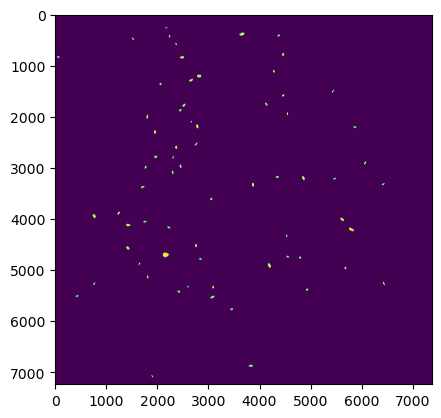

In [106]:
plt.imshow(gt)

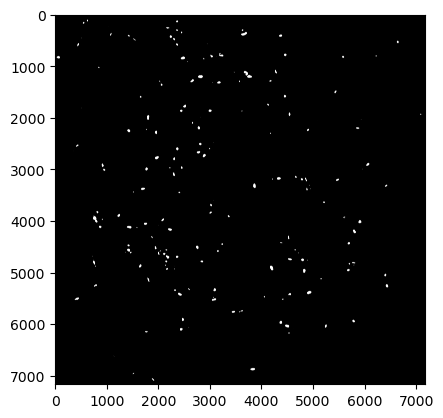

In [107]:
plt.imshow(big_pred, cmap='gray')

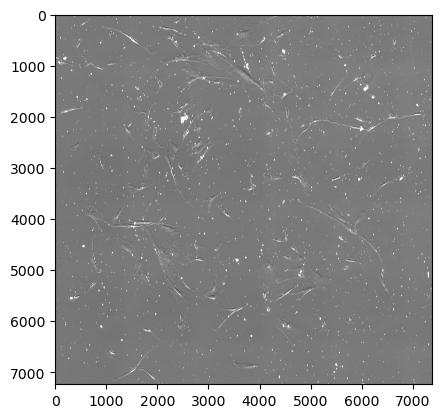

In [98]:
plt.imshow(img, cmap='gray')

In [90]:
gt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [91]:
gt = cv2.imread('../../newdataset_2023_03_24/data/cropped_wsi_mask/1452-1884.tif', cv2.IMREAD_GRAYSCALE)
cnts = cv2.findContours(gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(cnts[0])

68

In [48]:
oos_path = Path('../../newdataset_2023_03_24/data/cropped_wsi_mask')

[PosixPath('../../newdataset_2023_03_24/data/cropped_wsi_mask/3240-2364.tif'),
 PosixPath('../../newdataset_2023_03_24/data/cropped_wsi_mask/0084-0048.tif'),
 PosixPath('../../newdataset_2023_03_24/data/cropped_wsi_mask/1848-2112.tif'),
 PosixPath('../../newdataset_2023_03_24/data/cropped_wsi_mask/0552-0864.tif'),
 PosixPath('../../newdataset_2023_03_24/data/cropped_wsi_mask/1452-1884.tif')]

## Discussion and further research

Summing up, in this project we have

- Prepared a dataset of images from real-world experimental data.
- Prepared a dataset of ground truths, tagging by hand the images.
- Create a semantic segmentation model that could be fit for our purposes, namely the U-Net.
- Explored the hyperparameter space, in such a way to find the optimal parameter choice.
- Chosen a hyperparameter set, and trained a model on this optimal choice.
- Tested the model against out of sample images for a qualitative and quantitative check.

What could be done to further improve the predictions? There are several ideas
that come to mind.

- First of all, **further exploring the hyperparameter space** is a good idea.
We have tweaked the loss function and the depth of the network, but there
are many more parameters that can be changed such as: the number of filters,
the choice of the learning schedule, the dropout ratio, etc.
- Also, there are many **alternative DNN structures** that take inspiration from the
U-Net but evolve it in many different ways: U-Net++ and U-Net3+ are some
examples, or also U-Net with Attention Gates. The former variants play on
the addition of more sophisticated skip connections, while the latter adds
attention mechanism that might help to speed up the learning process.
- One common practice that also might help to speed up the learning process is
to **use a pre-trained backbone** such as VGG16, ResNet35, ResNet101, etc.
trained on e.g. ImageNet. Usually the backbone replaces the U-Net encoder,
and the decoder remains the same. The basic principle behind this idea is that
pre-trained backbones, whatever they were trained on, are already able to
detect *objects* in general: we can fine-tune them to find the object we want.
These might turn out to be computationally expensive solutions.
- More sophisticated **augmentation routines** might help the training process
to learn better.
- Another idea might be to perform **instance segmentation** instead of **semantic
segmentation**, but also these might turn out to be more computationally
expensive and not really essential as long as we do not want to perform segmentation
at confluent stages of cells.

## Takeaway

The aim of this work was to find a way in which we could augment the tracking
process by improving segmentation over cells, in particular by developing a
deep neural network solution that could be able to tell apart cells apart by
spotting their nuclei. The novelty of this work consists of the typology of
cells that we have been able to segment in this particular microscopy setting:
**fibroblastoid cells nuclei** imaging performed with **phase contrast
microscopy**.